# Postprocessing

We're going to process some sorting results, and calculate
- Waveforms
- Templates
- Features. Such as amplitudes, PCAs etc.

This is good chance to visualize some of the output, and look for suspicious sorted units!

For this tutorial, we'll use some simulated data that has already been sorted. This can be found in the `dataset_postprocessing` folder.

In [2]:
import spikeinterface as si
import spikeinterface.postprocessing as sipp
import spikeinterface.widgets as sw

from pathlib import Path

base_folder = Path("/home/samuel/DataSpikeSorting/gdr2024_tutorials")

postprocessing_folder = base_folder/"dataset_postprocessing"

recording = si.load_extractor(postprocessing_folder / "recording")
sorting = si.load_extractor(postprocessing_folder / "sorting_mysterious")

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/base.py:1129: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.0 is recommended
  warnings.warn(


Let's take a look...

In [3]:
recording

BinaryFolderRecording: 32 channels - 30.0kHz - 1 segments - 4,500,000 samples 
                       150.00s (2.50 minutes) - float32 dtype - 549.32 MiB

In [4]:
sorting

NumpyFolder: 67 units - 1 segments - 30.0kHz

Now we'll combine these into a a single sorting analyzer called `analyzer_in_memory`.

By default, the analyzer is saved in memory. When it's in memory, computations involving the analyzer are very fast. But, of course, this takes up memory.

In [5]:
analyzer_in_memory = si.create_sorting_analyzer(sorting=sorting, recording=recording)


/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


estimate_sparsity:   0%|          | 0/150 [00:00<?, ?it/s]

Note that when you create a sorting analyzer, it automatically calculates the _sparsity_. This creates a mask for each unit, so that only relevant channels are kept. This can greatly speed up computation for high density probes. We'll see it in action later!

If your working locally (e.g. on your laptop at a workshop) you'll probably want to save your analyzer in a folder. Let's do that now


In [6]:
analyzer = analyzer_in_memory.save_as(format="binary_folder", folder="my_sorting_analyzer")

Note that `analyzer_in_memory` is still in memory, while analyzer is not. 

_{ Note: you can save your analyzer in a folder from the start by running:_ \
_analyzer = si.create_sorting_analyzer(sorting=sorting, recording=recording, format="binary_folder", folder="my_sorting_analyzer")_ }

In [7]:
print(analyzer)
print(analyzer_in_memory)

SortingAnalyzer: 32 channels - 67 units - 1 segments - binary_folder - sparse - has recording
Loaded 0 extensions
SortingAnalyzer: 32 channels - 67 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions


## Extensions

The physical information we're interested in is computed using _extensions_. We can compute the `waveform` extension as follows:

In [8]:
analyzer.compute("waveforms")

AssertionError: Extension waveforms requires random_spikes to be computed first

Oh no - an error! The waveforms extensions requires the random_spikes extension. In fact, many extensions depend on other extensions. Here are all the current extension in spike interface and how they depend on one another:

![Hello](parent_child.svg)

So, we should calculate `random_spikes` as well as waveforms. In fact we can calculate several extensions in one funciton call. Here we'll calculate random_spikes, waveforms and templates:

In [9]:
si.set_global_job_kwargs(n_jobs=4)
analyzer.compute(["random_spikes", "waveforms", "templates"])

compute_waveforms:   0%|          | 0/150 [00:00<?, ?it/s]

Since `analyzer` is saved as a folder, the extensions will appear in the folder too. Let's have a look...

...

...

...

Great! 

What happens when you recalculate an extension? Well, it depends what it depends on. For example, waveforms depend on random spikes. This is because the waveforms are calculated using a random sampling of spikes. So if we recalculate random spikes, we'll get different waveforms. If our random sampling is good and representative, the waveforms won't change much. But they do. So if we recalculate random spikes, then our waveforms are inconsistent with our new random spikes. To keep things consistent when extensions are recomputed, spikeinterface _deletes_ the extensions which depend on the recomputed extension. Let's see this in action:

In [10]:
analyzer.compute("random_spikes")

Deleting waveforms
Deleting templates


Now, check your folder. The waveforms and templates are gone.

But we do want them for this tutorial. So let's calculate them again.

In [11]:
analyzer.compute(["waveforms", "templates"])

compute_waveforms:   0%|          | 0/150 [00:00<?, ?it/s]

You can access the extension data using the `get_extension` and `get_data` methods.

In [12]:
analyzer.get_extension("templates").get_data()

array([[[ 0.43160763,  0.15856522, -1.64553845, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.60825729,  1.18954945, -0.39359748, ...,  0.        ,
          0.        ,  0.        ],
        [-0.2589263 , -1.46931279, -0.71999538, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.51037842, -0.2437956 ,  0.41960892, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.17971826,  0.36650574, -0.02928694, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.05032032,  0.55643433,  1.22105205, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.61743432,  1.66682482,  0.1112477 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.68053645,  0.02588113, -0.02557991, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.45151785,  0.95628989,  0.54656368, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.25663525, -0.55959141, -0.74613774, ...,  

But it's a little awkward to work with without visualization...

Soon, we'll visualise lots of interesting stuff. These will rely on the more extensions, which we'll now calculate in a slightly different way: using a dictionary. This might suit your coding style better.

In [13]:
extensions_to_compute = {
    #'principal_components': {
    #    'n_components': 4
    #},
    'spike_amplitudes': {},
    'amplitude_scalings': {},
    'spike_locations': {},
    'template_metrics': {},
    'template_similarity': {},
    'unit_locations': {
        'method': 'monopolar_triangulation'
    },
}

analyzer.compute(extensions_to_compute)

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/sortinganalyzer.py:2043: UserWarning: Found no run_info file for template_metrics, extension should be re-computed.
  warnings.warn(f"Found no run_info file for {self.extension_name}, extension should be re-computed.")
/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/sortinganalyzer.py:2050: UserWarning: Found no run_info file for template_metrics, extension should be re-computed.
  warnings.warn(f"Found no run_info file for {self.extension_name}, extension should be re-computed.")
/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/sortinganalyzer.py:2125: UserWarning: Found no data for template_metrics, extension should be re-computed.
  warnings.warn(f"Found no data for {self.extension_name}, extension should be re-computed.")


Compute : spike_amplitudes + amplitude_scalings + spike_locations:   0%|          | 0/150 [00:00<?, ?it/s]

### Exercises

1. Run this notebook
2. Save the sorting analyzer using the Zarr format. More details here: https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html
3. Try varying the keywords in one of the extensions. More details here: https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html#available-postprocessing-extensions
4. Run the next code block, the first one in the "Widgets" section.

## Widgets

We'll now have a look at the information we've calculated, using a _widget_. These are used to make graphical, interactive output in Jupyter notebooks. They can be a bit fiddely to set up. For instance, some of the most interactive features fail in VSCode (for me!).

Let's plot the unit summary. This contains the unit location, template, template on the most important channel, the autocorrelogram and the amplitude density plot (phew!)

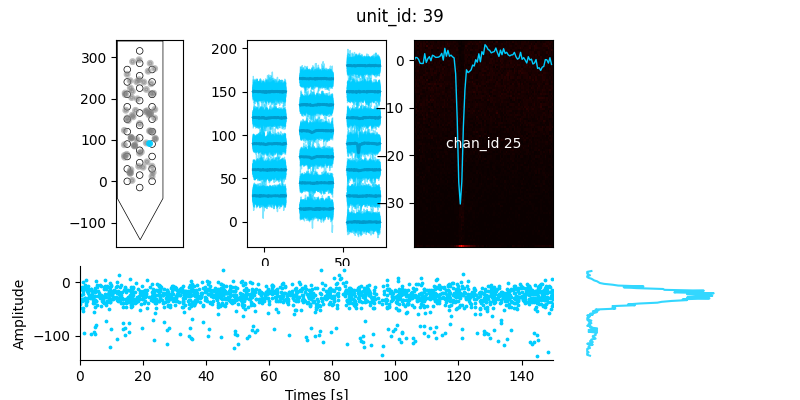

In [14]:
# activate the matplotlib widget
import matplotlib.pyplot
%matplotlib widget

sw.plot_unit_summary(analyzer, unit_id=39, figsize=(8,4))

_(Note: the recording has 32 channels, but only ~15 are shown. This is thanks to the sparisty discussed earlier.)_

Beautiful! There are _a lot_ of widgets: https://spikeinterface.readthedocs.io/en/latest/modules/widgets.html#available-plotting-functions

They can be very useful when checking if your units look reasonable. For instance, we can have a look at the unit locations. One way is to get the data and have a look:

In [15]:
print(analyzer.get_extension("unit_locations").get_data())

[[ 8.70470163e+00  2.80687737e+01  1.00000000e+00]
 [-5.96413298e+00  5.82513260e+01  1.00000000e+00]
 [ 9.43547363e+00  1.04298536e+02  6.64610291e+00]
 [-7.03502586e+00  8.83500134e+01  1.00000000e+00]
 [ 5.62774691e+01  1.21433605e+02  2.36101611e+00]
 [-6.97815640e+00  1.23087418e+02  1.00000000e+00]
 [ 1.39583174e+01  1.55742985e+02  9.31243339e+00]
 [-1.53439298e-01  1.52973765e+02  1.07875594e+00]
 [ 1.07182960e+01  2.02279303e+02  1.63089693e+01]
 [ 2.00135552e+01  1.71395600e+02  1.00052171e+00]
 [-3.51602280e+00  1.71727402e+02  1.00000003e+00]
 [ 2.87760633e+01  2.45568271e+02  1.38181708e+00]
 [-4.63573628e+00  2.09570081e+02  1.23354939e+00]
 [ 7.35104700e+00  2.25605404e+02  1.00000000e+00]
 [ 2.28091189e+01  2.40512171e+02  1.09689757e+01]
 [ 1.29344163e+01  2.89049806e+02  1.00000000e+00]
 [ 6.87333981e+00  1.96596795e+01  1.00000000e+00]
 [ 2.76029564e+01  3.63375583e+01  1.00000000e+00]
 [ 3.39318339e+01  7.10287188e+01  4.81521333e+00]
 [ 2.97014400e+01  6.78988082e+

Another way is to use a widget:


In [16]:
sw.plot_unit_locations(analyzer, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

Earlier, I had a look at the data and noticed that units 0, 16, 29 and 34 were very close together...

Units that are close together are candidates for oversplitting. Maybe our sorting algorithm has split one unit into two. We can investigate how similar their firing rates are by looking at the cross correlograms.

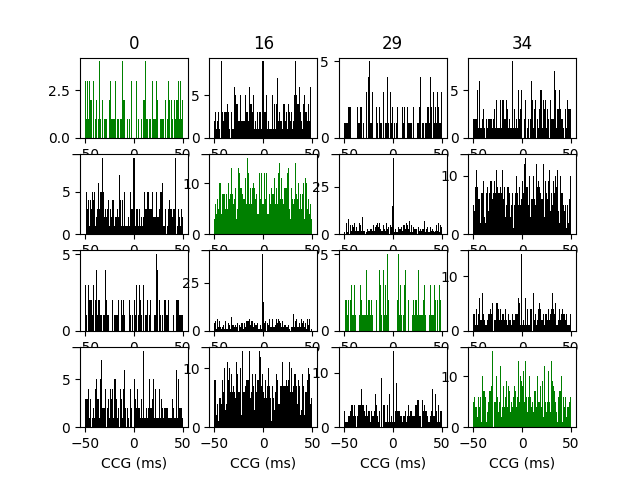

In [17]:
sw.plot_crosscorrelograms(analyzer.sorting,  unit_ids=[0,16,29,34])

Very suspicious! Units 16 and 29 almost always spike at the same time. Let's take a look at their templates...

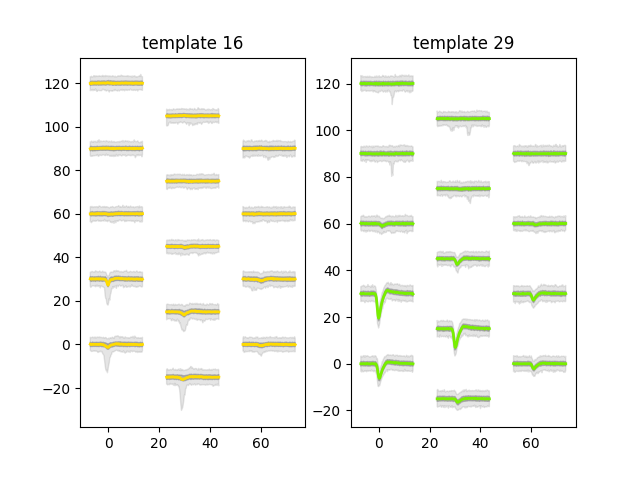

In [18]:
sw.plot_unit_templates(analyzer, unit_ids=[16,29])

Should these be merged? That's not the point of this tutorial! Instead, we've seen how the widgets can be used to do some detective work. Another very useful widget is related to spike amplitudes:

In [19]:
sw.plot_amplitudes(analyzer, plot_histograms=True, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

Two things to look out for: drift and sudden amplitude cut-offs.
There's also a nice way to view all the amplitude distributions at once:

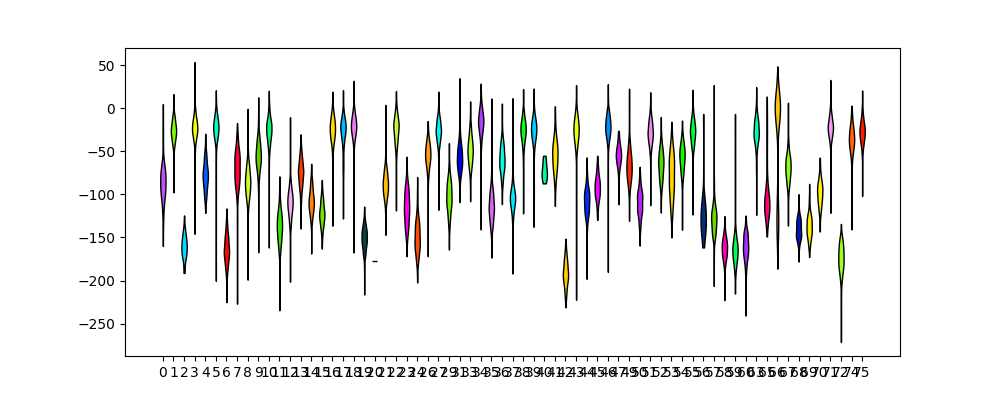

In [20]:
sw.plot_all_amplitudes_distributions(analyzer, figsize=(10,4))

### Exercises

1. Run this notebook
2. Go have a look at the **Widget Tutorial** page of the documentation: (https://spikeinterface.readthedocs.io/en/latest/tutorials/index.html#widgets-tutorials)
and plot a widget we've not looked at yet. Note: some of the widgets take in a _recording_ or _sorting_. For these you need to pass `analyzer.recording` or `analyzer.sorting` instead of `analyzer`.
3. Try and find a suspicious unit. One that should be merged or split!



# END

That's the end of this notebook. Hopefully you've learned about
- Combining your recording and sorting into a sorting analyzer
- Calculating extensions, their dependences and what happens when you recompute
- Accessing extension data and visualising them using widgets